## Node Classfication GNN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

In [4]:
# Load Pubmed dataset
dataset = Planetoid(root='data/Pubmed', name='Pubmed')
data = dataset[0]

In [5]:
# GCN Model definition
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 64)
        self.conv2 = GCNConv(64, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [6]:
# Training function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
# Evaluation function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        preds = out.argmax(dim=1)
        test_correct = preds[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [8]:
# Visualization function using t-SNE
def visualize(h, color, path):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.title("t-SNE of Node Embeddings")
    plt.savefig(path)
    plt.show()

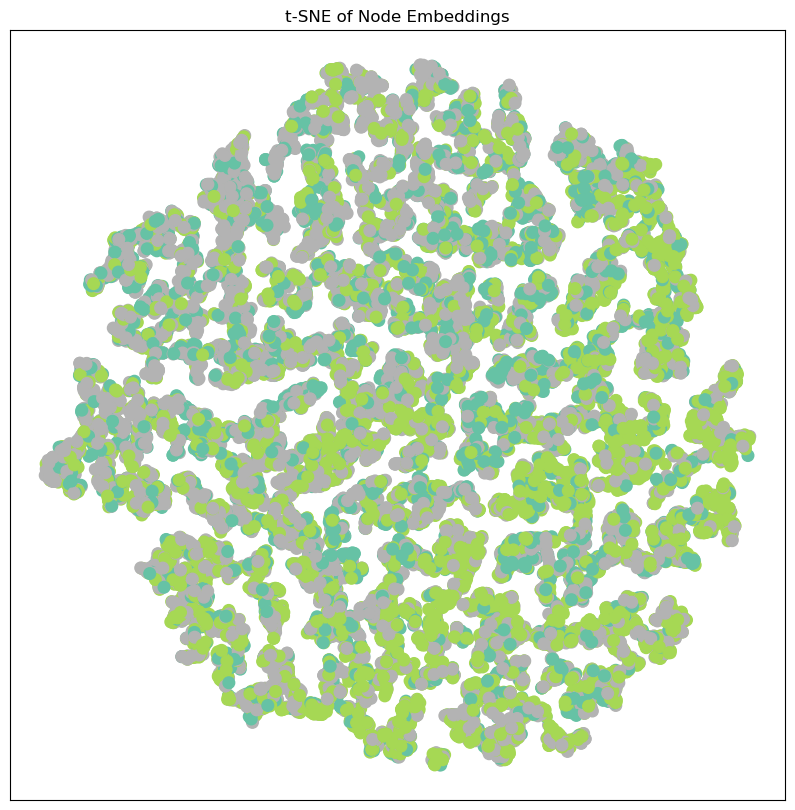

Epoch: 0, Loss: 1.0972, Train Acc: 0.6970
Epoch: 10, Loss: 0.6246, Train Acc: 0.7380
Epoch: 20, Loss: 0.2247, Train Acc: 0.7680
Epoch: 30, Loss: 0.0705, Train Acc: 0.7680
Epoch: 40, Loss: 0.0242, Train Acc: 0.7630
Epoch: 50, Loss: 0.0112, Train Acc: 0.7550
Epoch: 60, Loss: 0.0067, Train Acc: 0.7540
Epoch: 70, Loss: 0.0048, Train Acc: 0.7570
Epoch: 80, Loss: 0.0038, Train Acc: 0.7600
Epoch: 90, Loss: 0.0032, Train Acc: 0.7600
Epoch: 100, Loss: 0.0027, Train Acc: 0.7600
Epoch: 110, Loss: 0.0024, Train Acc: 0.7590
Epoch: 120, Loss: 0.0021, Train Acc: 0.7600
Epoch: 130, Loss: 0.0019, Train Acc: 0.7590
Epoch: 140, Loss: 0.0017, Train Acc: 0.7600
Epoch: 150, Loss: 0.0015, Train Acc: 0.7600
Epoch: 160, Loss: 0.0014, Train Acc: 0.7600
Epoch: 170, Loss: 0.0012, Train Acc: 0.7600
Epoch: 180, Loss: 0.0011, Train Acc: 0.7580
Epoch: 190, Loss: 0.0010, Train Acc: 0.7580


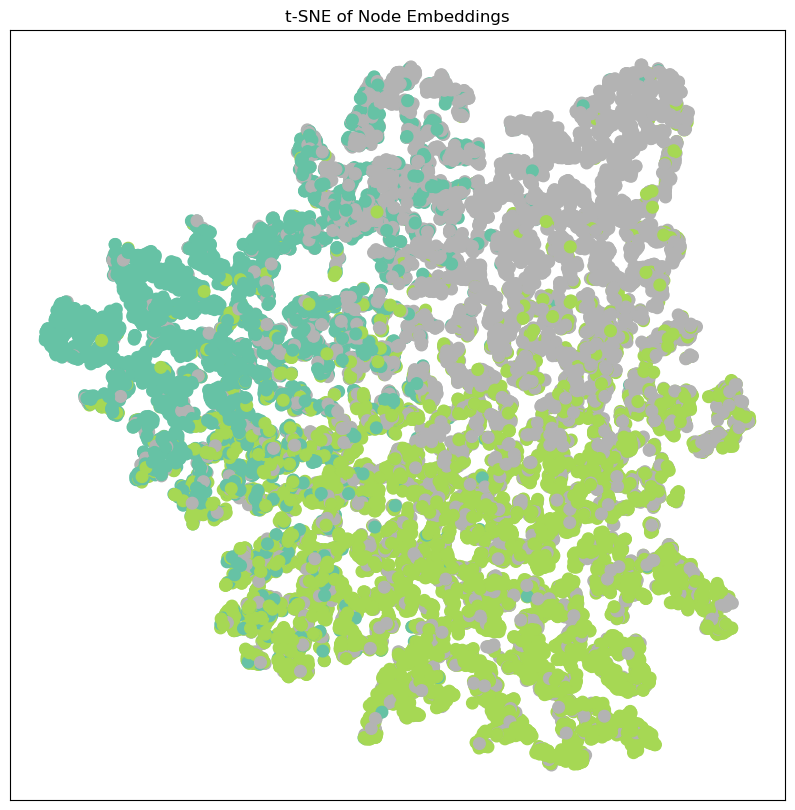

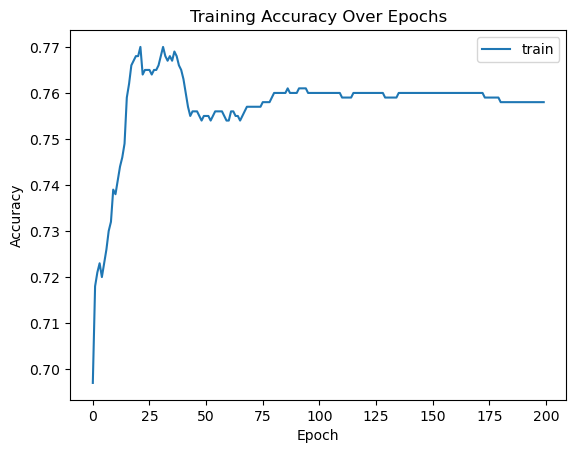

In [9]:
# Main training loop
def main():
    model = GCN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    train_acc_list = []
    epochs = 200

    # Visualize node embeddings before training
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        visualize(out, color=data.y, path='tsne_pre_training.png')

    for epoch in range(epochs):
        loss = train(model, data, optimizer, criterion)
        train_acc = evaluate(model, data)
        train_acc_list.append(train_acc)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}')

    # Visualize node embeddings after training
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        visualize(out, color=data.y, path='tsne_post_training.png')

    # Plotting training accuracy
    plt.plot(range(epochs), train_acc_list, label='train')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.legend()
    plt.savefig('training_accuracy_plot.png')
    plt.show()

if __name__ == "__main__":
    main()